## Model Training and Hyperparameter Optimization

In this study, we build a machine learning pipeline to predict heart disease using a **Random Forest classifier**.  
The dataset is first split into training and test sets to ensure unbiased evaluation.

We begin with a **baseline Random Forest model** to establish initial performance.  
Model performance is evaluated using **accuracy, precision, recall, and F1-score**.

To improve the model, we apply **hyperparameter tuning** using:
- **RandomizedSearchCV** to efficiently explore a wide range of parameter combinations
- **GridSearchCV** to fine-tune the best-performing parameters from the random search

All models are implemented using **scikit-learn Pipelines**, ensuring clean code structure, reproducibility, and preventing data leakage during cross-validation.

Finally, we compare the baseline, randomized search, and grid search models to identify the best-performing configuration.


## 1 - Imports

In [1]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline


## 2 - Load data & train-test split

In [2]:
heart_disease = pd.read_csv("heart-disease.csv")

X = heart_disease.drop("target", axis=1)
y = heart_disease["target"]

np.random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2
)


## 3 - Evaluation function

In [4]:
def evaluate_preds(y_true, y_preds):
    accuracy = accuracy_score(y_true, y_preds)
    precision = precision_score(y_true, y_preds)
    recall = recall_score(y_true, y_preds)
    f1 = f1_score(y_true, y_preds)

    print(f"Acc: {accuracy * 100:.2f}%")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 score: {f1:.2f}")

    return {
        "accuracy": round(accuracy, 2),
        "precision": round(precision, 2),
        "recall": round(recall, 2),
        "f1": round(f1, 2)
    }


## 4 - Baseline Pipeline

In [5]:
baseline_pipeline = Pipeline([
    ("model", RandomForestClassifier(
        random_state=42,
        n_jobs=-1
    ))
])

baseline_pipeline.fit(X_train, y_train)

baseline_preds = baseline_pipeline.predict(X_test)
baseline_metrics = evaluate_preds(y_test, baseline_preds)


Acc: 83.61%
Precision: 0.84
Recall: 0.84
F1 score: 0.84


## 5 - RandomizedSearchCV with Pipeline

In [6]:
param_dist = {
    "model__n_estimators": [100, 200, 500, 1000],
    "model__max_depth": [None, 5, 10, 20, 30],
    "model__max_features": ["sqrt", "log2"],
    "model__min_samples_split": [2, 4, 6],
    "model__min_samples_leaf": [1, 2, 4],
    "model__class_weight": [None, "balanced"]
}

rs_pipeline = RandomizedSearchCV(
    estimator=baseline_pipeline,
    param_distributions=param_dist,
    n_iter=10,
    cv=5,
    scoring="f1",
    verbose=2,
    random_state=42,
    n_jobs=-1,
    refit=True
)

rs_pipeline.fit(X_train, y_train)

rs_preds = rs_pipeline.predict(X_test)
rs_metrics = evaluate_preds(y_test, rs_preds)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Acc: 85.25%
Precision: 0.85
Recall: 0.88
F1 score: 0.86


## 6 - GridSearchCV with Pipeline

In [7]:
param_grid = {
    "model__n_estimators": [100, 200, 500],
    "model__max_depth": [None],
    "model__max_features": ["sqrt", "log2"],
    "model__min_samples_split": [6],
    "model__min_samples_leaf": [1, 2]
}

gs_pipeline = GridSearchCV(
    estimator=baseline_pipeline,
    param_grid=param_grid,
    cv=5,
    scoring="f1",
    verbose=2,
    n_jobs=-1,
    refit=True
)

gs_pipeline.fit(X_train, y_train)

gs_preds = gs_pipeline.predict(X_test)
gs_metrics = evaluate_preds(y_test, gs_preds)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Acc: 86.89%
Precision: 0.85
Recall: 0.91
F1 score: 0.88


## 7 - Compare results

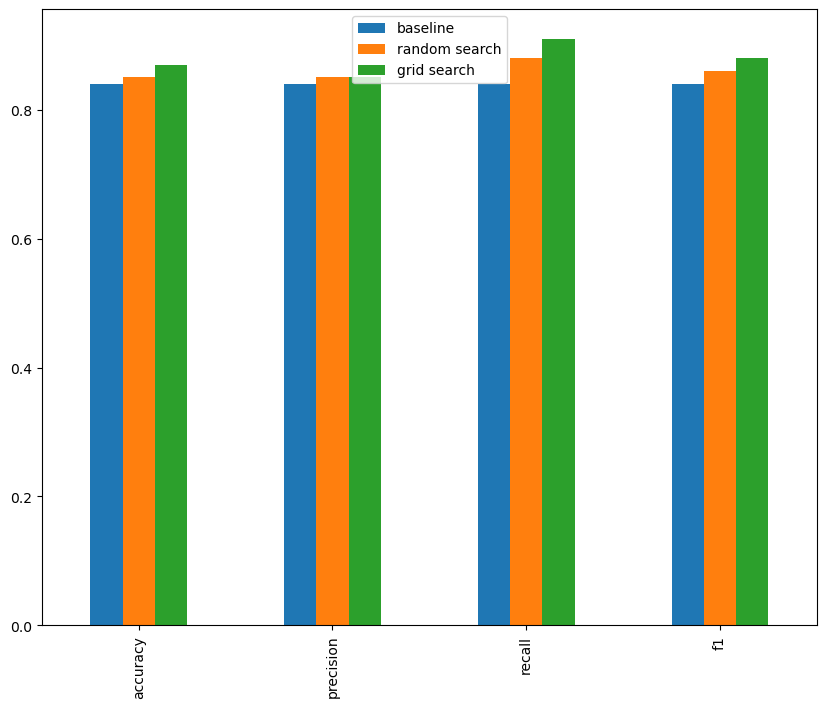

In [8]:
compare_metrics = pd.DataFrame({
    "baseline": baseline_metrics,
    "random search": rs_metrics,
    "grid search": gs_metrics
})

compare_metrics.plot.bar(figsize=(10, 8));
